# Домашнее задание  
## по теме «Линейная регрессия» 

### Импорт библиотек

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from eda_tools import return_outliers, return_boxplot, return_eda, detect_outliers_iqr

In [3]:
# загрузка DataFrame
df = pd.read_csv('input_data/train.csv') 

### Подготовка исходных данных

In [6]:
df.info(memory_usage=True) # Вывод столбцов и их типов
df.head() # Вывод 5 строк

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


Выводы. Часть столбцов треуют новых, красивых названий. Часть столбцов требуют измения типа данных на int

In [7]:
# Смена названий столбцов
df.rename(columns={
    'store_sales(in millions)': 'cash_sales',
    'unit_sales(in millions)': 'unit_sales',
    'avg_cars_at home(approx).1': 'avg_cars_home'
}, inplace=True)

### Описание столбцов:
- id	- идентификатор записи
- cash_sales - продажи в мл.долларов_евро_сша 
- unit_sales - продажи в штуках
- total_children - общее кол-во детей
- num_children_at_home - кол-во детей в комнате
- avg_cars_home - среднее кол-во автомобилей в доме
- gross_weight - Вес брутто
- recyclable_package - перерабатываемая упаковка
- low_fat - обезжиренный продукт
- units_per_case - кол-во в упаковке
- store_sqft - площадь магазина
- coffee_bar - наличие ковейни
- video_store	- наличие видеомагазина
- salad_bar - наличие малт-бара
- prepared_food - готовая еда
- florist	 - наличие флориста
- cost - стоимость рекламной кампании (ЦЕЛЕВАЯ ПЕРЕМЕННАЯ)


Построение тепловой матрицы корреляции

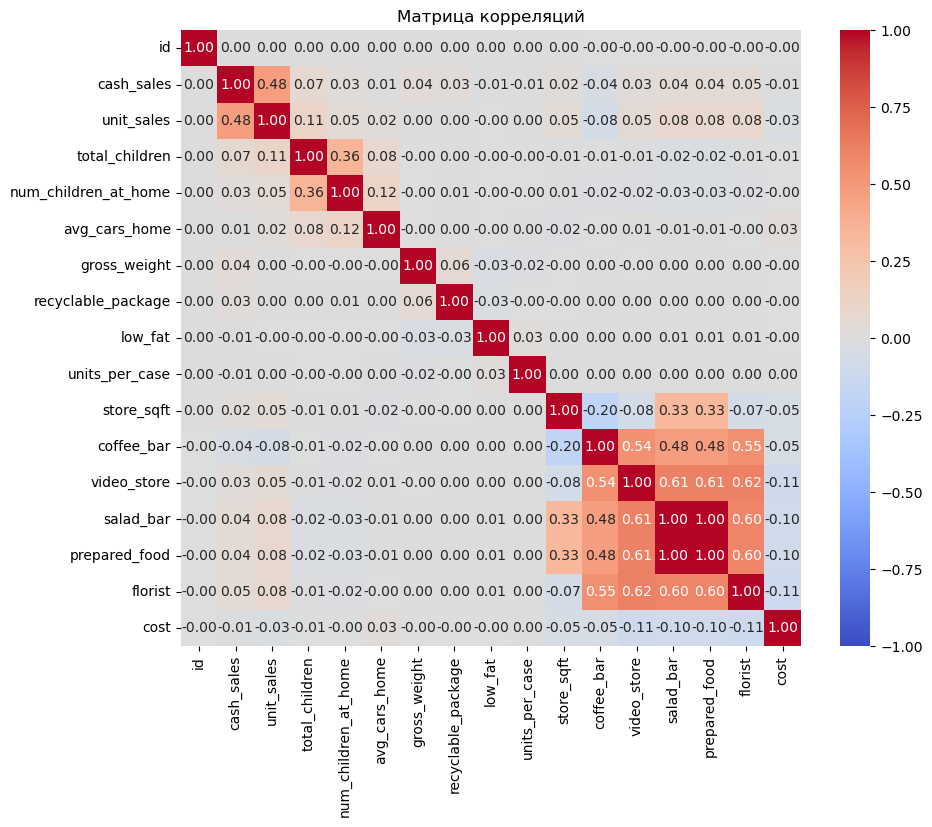

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляций')
plt.show()

Выводы:
- id, gross_weight, num_children_at_home,recyclable_package, units_per_case удаляю из за отсутвия корреляции с cost
- salad_bar, prepared_food сильная положительная корреляция между собой. Удаляю salad_bar,что бы избежать мультиколлериальности
- данные с cost слабо коллерируются, предпологаю модель будет очень плохой

In [9]:
# Удаление столбцов которые не влияют на cost
df = df.drop(columns=['id', 'gross_weight', 'num_children_at_home','recyclable_package', 'units_per_case', 'salad_bar' ])
                    #   , 'low_fat', 'units_per_case', 'salad_bar'])
# df = df.drop(columns=['video_store', 'prepared_food', 'coffee_bar', 'total_children','florist' ])

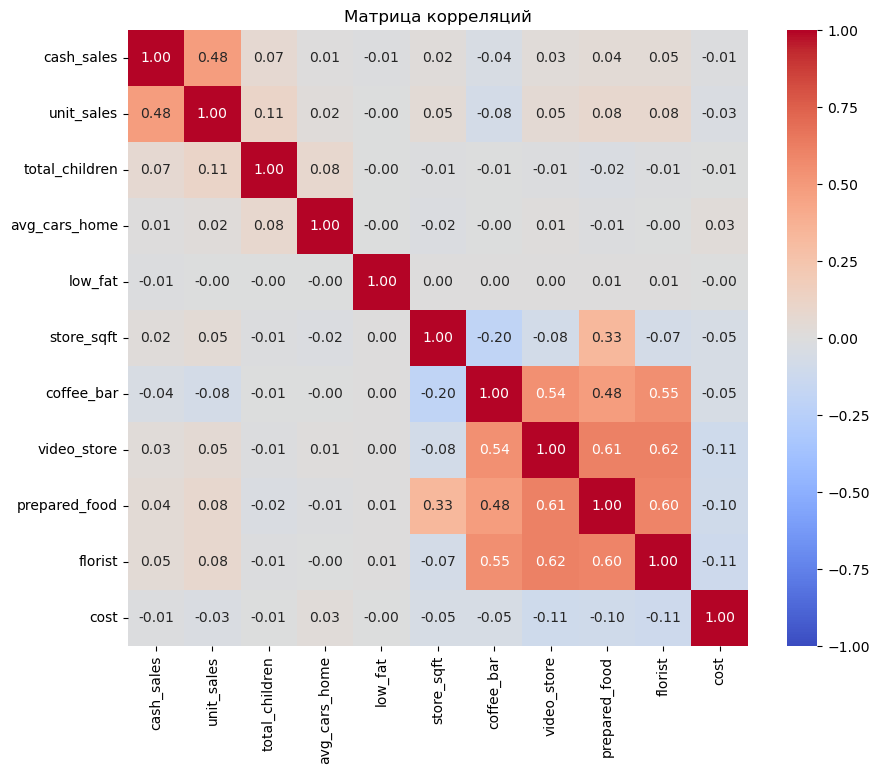

In [11]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляций')
plt.show()

EDA-анализ

In [12]:
eda_df = return_eda(df)
eda_df

,nan,Пропуски (%),Max,Min,AVG,Медиана,Дисперсия,q0.1,q0.9,Q1,Q3,Дробные,Var_type_df,nunique,count_0,Выбросы слева,Выбросы справа
Параметр,,,,,,,,,,,,,,,,,
cash_sales,0,0.0,22.92,0.51,6.337376,5.78,1.094273e+01,2.32,11.04,3.72,8.40,356907,float64,1044,0,0,3442
unit_sales,0,0.0,6.00,1.00,3.043881,3.00,6.157163e-01,2.00,4.00,3.00,4.00,0,float64,6,0,6765,31
total_children,0,0.0,5.00,0.00,2.456482,2.00,2.217097e+00,0.00,4.00,1.00,4.00,0,float64,6,36441,0,0
avg_cars_home,0,0.0,4.00,0.00,2.203813,2.00,1.175692e+00,1.00,4.00,1.00,3.00,0,float64,5,18537,0,0
low_fat,0,0.0,1.00,0.00,0.327797,0.00,2.203467e-01,0.00,1.00,0.00,1.00,0,float64,2,242219,0,0
store_sqft,0,0.0,39696.00,20319.00,28180.333442,27694.00,3.562746e+07,21215.00,38382.00,23593.00,33858.00,0,float64,20,0,0,0
coffee_bar,0,0.0,1.00,0.00,0.564839,1.00,2.457965e-01,0.00,1.00,0.00,1.00,0,float64,2,156804,0,0
video_store,0,0.0,1.00,0.00,0.277394,0.00,2.004471e-01,0.00,1.00,0.00,1.00,0,float64,2,260381,0,0
prepared_food,0,0.0,1.00,0.00,0.504832,1.00,2.499773e-01,0.00,1.00,0.00,1.00,0,float64,2,178427,0,0


Выводы:
- пропусков нет
- есть выбросы в полях cash_sales, unit_sales
- требуется масштабирование перед обучением
- у части полей можно поменять типы данных на int

In [ ]:
# Меняю типы данных
# Проходим по строкам eda_df, где "Дробные" равно 0
for parameter in eda_df[eda_df['Дробные'] == 0].index:
    df[parameter] = df[parameter].astype(int)

Работа с выбросами

In [16]:
scaler = MinMaxScaler()
df['store_sqft'] = scaler.fit_transform(df[['store_sqft']])
eda_df = return_eda(df)
eda_df

,nan,Пропуски (%),Max,Min,AVG,Медиана,Дисперсия,q0.1,q0.9,Q1,Q3,Дробные,Var_type_df,nunique,count_0,Выбросы слева,Выбросы справа
Параметр,,,,,,,,,,,,,,,,,
cash_sales,0,0.0,22.92,0.51,6.337376,5.780000,10.942729,2.32000,11.040000,3.720000,8.400000,356907,float64,1044,0,0,3442
unit_sales,0,0.0,6.00,1.00,3.043881,3.000000,0.615716,2.00000,4.000000,3.000000,4.000000,0,int32,6,0,6765,31
total_children,0,0.0,5.00,0.00,2.456482,2.000000,2.217097,0.00000,4.000000,1.000000,4.000000,0,int32,6,36441,0,0
avg_cars_home,0,0.0,4.00,0.00,2.203813,2.000000,1.175692,1.00000,4.000000,1.000000,3.000000,0,int32,5,18537,0,0
low_fat,0,0.0,1.00,0.00,0.327797,0.000000,0.220347,0.00000,1.000000,0.000000,1.000000,0,int32,2,242219,0,0
store_sqft,0,0.0,1.00,0.00,0.405704,0.380606,0.094888,0.04624,0.932188,0.168963,0.698715,311453,float64,20,29193,0,0
coffee_bar,0,0.0,1.00,0.00,0.564839,1.000000,0.245797,0.00000,1.000000,0.000000,1.000000,0,int32,2,156804,0,0
video_store,0,0.0,1.00,0.00,0.277394,0.000000,0.200447,0.00000,1.000000,0.000000,1.000000,0,int32,2,260381,0,0
prepared_food,0,0.0,1.00,0.00,0.504832,1.000000,0.249977,0.00000,1.000000,0.000000,1.000000,0,int32,2,178427,0,0


In [324]:
# import pandas as pd

# Предположим, df — ваш DataFrame

# Шаг 1: Вычисляем среднее значение cost для каждого уникального значения unit_sales
target_encoding = df.groupby('unit_sales')['cost'].mean().to_dict()

# Шаг 2: Заменяем значения в unit_sales на соответствующие средние значения cost
df['unit_sales_encoded'] = df['unit_sales'].map(target_encoding)

# Вывод результата
print(df[['unit_sales', 'unit_sales_encoded']].head())

   unit_sales  unit_sales_encoded
0         3.0           99.378377
1         2.0          100.492636
2         4.0           98.935700
3         3.0           99.378377
4         3.0           99.378377


In [325]:


# # масштабирование данных
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df['store_sqft'] = df['store_sqft']/10000
df['cost'] = df['cost']/10
df['cash_sales'] = df['cash_sales']/10

In [326]:
eda_df = return_eda(df)
eda_df

,nan,Пропуски (%),Max,Min,AVG,Медиана,Дисперсия,q0.1,q0.9,Q1,Q3,Дробные,Var_type_df,nunique,count_0,Выбросы слева,Выбросы справа
Параметр,,,,,,,,,,,,,,,,,
cash_sales,0,0.0,2.292000,0.05100,0.633738,0.578000,0.109427,0.2320,1.104000,0.3720,0.840000,360235,float64,1044,0,0,3442
unit_sales,0,0.0,6.000000,1.00000,3.043881,3.000000,0.615716,2.0000,4.000000,3.0000,4.000000,0,float64,6,0,6765,31
total_children,0,0.0,5.000000,0.00000,2.456482,2.000000,2.217097,0.0000,4.000000,1.0000,4.000000,0,float64,6,36441,0,0
avg_cars_home,0,0.0,4.000000,0.00000,2.203813,2.000000,1.175692,1.0000,4.000000,1.0000,3.000000,0,float64,5,18537,0,0
low_fat,0,0.0,1.000000,0.00000,0.327797,0.000000,0.220347,0.0000,1.000000,0.0000,1.000000,0,float64,2,242219,0,0
store_sqft,0,0.0,3.969600,2.03190,2.818033,2.769400,0.356275,2.1215,3.838200,2.3593,3.385800,360336,float64,20,0,0,0
coffee_bar,0,0.0,1.000000,0.00000,0.564839,1.000000,0.245797,0.0000,1.000000,0.0000,1.000000,0,float64,2,156804,0,0
video_store,0,0.0,1.000000,0.00000,0.277394,0.000000,0.200447,0.0000,1.000000,0.0000,1.000000,0,float64,2,260381,0,0
prepared_food,0,0.0,1.000000,0.00000,0.504832,1.000000,0.249977,0.0000,1.000000,0.0000,1.000000,0,float64,2,178427,0,0


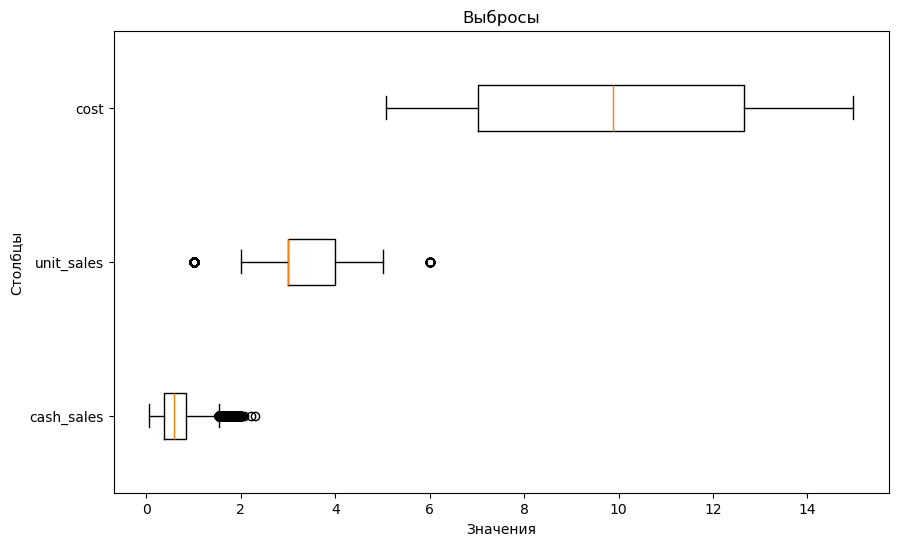

In [327]:
# Посмотрим на выбросы
df_filtered = df[['cash_sales', 'unit_sales', 'cost']] # Столбцы в ручную  переделать на eda_df
return_boxplot(df_filtered, 'Выбросы').show()

Выводы:
- cash_sales. Беда!!!  Пожертвую 0,95% данных.
- количество продаж в штуках имеет всего 6 значений, категориальный?. Нет времени Пожертвую еще частью данных (примерно-3% данных)

In [328]:
Q1 = df['cash_sales'].quantile(0.25)  # Первый квартиль (25-й процентиль)
Q3 = df['cash_sales'].quantile(0.75)  # Третий квартиль (75-й процентиль)
IQR = Q3 - Q1  # Межквартильный размах

# Шаг 2: Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Шаг 3: Удаляем выбросы
# Оставляем только те строки, где значения находятся в пределах [lower_bound, upper_bound]
df = df[(df['cash_sales'] >= lower_bound) & (df['cash_sales'] <= upper_bound)]

In [329]:
Q1 = df['unit_sales'].quantile(0.25)  # Первый квартиль (25-й процентиль)
Q3 = df['unit_sales'].quantile(0.75)  # Третий квартиль (75-й процентиль)
IQR = Q3 - Q1  # Межквартильный размах

# Шаг 2: Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Шаг 3: Удаляем выбросы
# Оставляем только те строки, где значения находятся в пределах [lower_bound, upper_bound]
df = df[(df['unit_sales'] >= lower_bound) & (df['unit_sales'] <= upper_bound)]

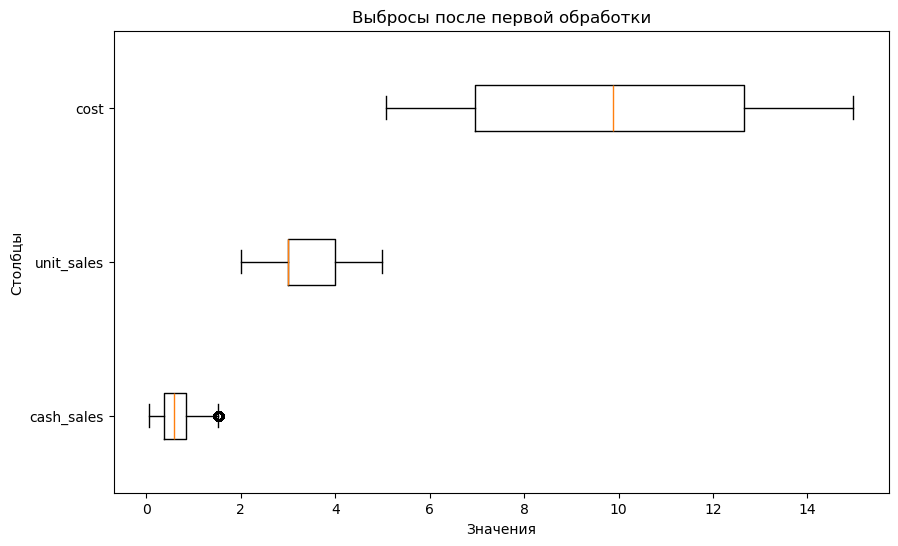

In [330]:
# Посмотрим на выбросы
df_filtered = df[['cash_sales', 'unit_sales', 'cost']]
return_boxplot(df_filtered, 'Выбросы после первой обработки').show()

Выбросы в cash_sales появилсиь новые, но сосредоточены у правого края. Заменю на верхний уровень

In [331]:
def get_iqr_bounds(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Вычисляем границы для каждого столбца
g_lower, g_upper = get_iqr_bounds(df['cash_sales'])

df['cash_sales'] = df['cash_sales'].clip(upper=g_upper)


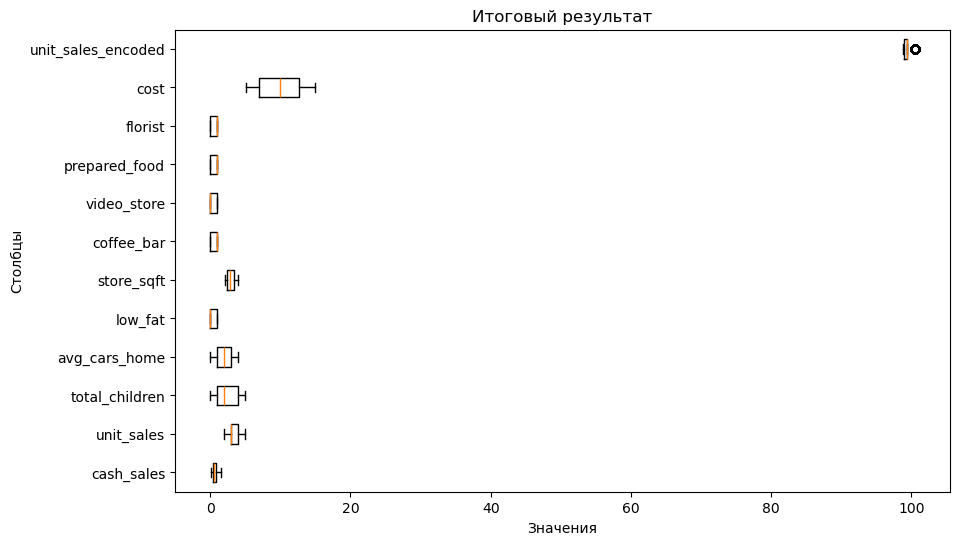

In [332]:
return_boxplot(df, 'Итоговый результат').show()

Ну так, что то похоже... Напишите, если не затруднит, в чем мои ошибки.

In [333]:
# Выделяем целевую переменную и признаки
X = df.drop(columns=['cost'])  # Признаки (все столбцы, кроме 'id' и 'cost')
X
# X = df['cash_sales', 'store_sqft']
y = df['cost']  # Целевая переменная

# Добавляем константу для statsmodels (для intercept)
X = sm.add_constant(X)

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Шаг 2: Регрессия с помощью statsmodels (OLS)
model_sm = sm.OLS(y_train, X_train).fit()  # Обучаем модель
# print(model_sm.summary())  # Выводим статистику модели

# Шаг 3: Регрессия с помощью scikit-learn
model_sk = LinearRegression()
model_sk.fit(X_train.drop(columns=['const']), y_train)  # Обучаем модель (const не нужен для scikit-learn)

# Шаг 4: Предсказания
y_pred_sm = model_sm.predict(X_test)  # Предсказания для statsmodels
y_pred_sk = model_sk.predict(X_test.drop(columns=['const']))  # Предсказания для scikit-learn

# Шаг 5: Оценка качества модели
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE в процентах
    r2 = r2_score(y_true, y_pred)  # R² (коэффициент детерминации)

    print(f"Метрики для модели {model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"R²: {r2:.4f}")
    print()

# Оценка для statsmodels
evaluate_model(y_test, y_pred_sm, "statsmodels OLS")

# Оценка для scikit-learn
evaluate_model(y_test, y_pred_sk, "scikit-learn LinearRegression")

Метрики для модели statsmodels OLS:
MAE: 2.5644
MSE: 8.8245
RMSE: 2.9706
MAPE: 29.7923%
R²: 0.0197

Метрики для модели scikit-learn LinearRegression:
MAE: 2.5644
MSE: 8.8245
RMSE: 2.9706
MAPE: 29.7923%
R²: 0.0197

